<a href="https://colab.research.google.com/github/Dias04404/sistemas-energia-eolica/blob/main/Atividade_04_Caico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Estimativa dos parâmetros e cálculo da Potência*

## DataSet

In [2]:
#### IMPORTAR BIBLIOTECAS ####
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore') # Ignora warnings no github
from IPython.display import Image

#### SCIPY ####
from scipy.special import gamma
from scipy.optimize import minimize
from scipy.stats import weibull_min
from scipy.optimize import minimize_scalar


#### IMPORTAR DADOS ####
from google.colab import drive
drive.mount('/content/drive')
pasta = '/content/drive/MyDrive/eolica/caico' # DEFINIR PASTA COM OS CSVs

#### CRIA LISTAS ####
arquivos = [f for f in os.listdir(pasta) if f.lower().endswith('.csv')]
lista_df = [] # LISTA COM DATAFRAMES
colunas_remover = [ # LISTA COM COLUNAS PARA REMOVER
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
    'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
    'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
    'RADIACAO GLOBAL (KJ/m²)',
    'RADIACAO GLOBAL (Kj/m²)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'TEMPERATURA DO PONTO DE ORVALHO (°C)',
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
    'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'Unnamed: 19',
    'Hora UTC', ''  # caso apareça
]

#### PREPARAÇÃO DOS CASOS ESPECIAIS ####
def ler_arquivo_inmet(caminho): # FUNÇÃO PARA LER E NORMALIZAR ARQUIVOS A PARTIR DE 2019
    with open(caminho, 'r', encoding='latin1') as f:  # CODIFICA PARA LEITURA DOS ARQUIVOS
        linhas = f.readlines()[8:]  # PULA OS METADADOS
        linhas = [linha.strip() for linha in linhas if linha.strip()]
    dados = [linha.split(';') for linha in linhas]  # CONVERTE O SEPARADOR DE COLUNAS
    df = pd.DataFrame(dados)
    colunas = df.iloc[0]  # TRANSFORMA A PRIMEIRA LINHA EM NOME DAS COLUNAS
    df = df[1:]  # REMOVE A PRIMEIRA LINHA DO DF
    df.columns = colunas
    df = df.loc[:, ~df.columns.duplicated()]
    df.drop(columns=[col for col in colunas_remover if col in df.columns], inplace=True)  # REMOVE LISTA DE COLUNAS
    return df

#### PROCESSAR ARQUIVOS ####
for arquivo in arquivos:
    caminho = os.path.join(pasta, arquivo)
    try:
        # VERIFICA SE O ARQUIVO É DE 2019 OU MAIS RECENTE
        if any(ano in arquivo for ano in ['2019', '2020', '2021', '2022', '2023', '2024']):
            df = ler_arquivo_inmet(caminho) # RODA A FUNÇÃO
        else:
            df = pd.read_csv(
                caminho,
                skiprows=8,
                encoding='latin1',
                sep=';',
                decimal=',',
                on_bad_lines='skip'
            )
            df = df.loc[:, ~df.columns.duplicated()]
            df.drop(columns=[col for col in colunas_remover if col in df.columns], inplace=True)

        # RENOMEIA A COLUNA DE DATA
        if 'DATA (YYYY-MM-DD)' in df.columns:
            df.rename(columns={'DATA (YYYY-MM-DD)': 'Data'}, inplace=True)
        # RENOMEIA A COLUNA DE VELOCIDADE
        if 'VENTO, VELOCIDADE HORARIA (m/s)' in df.columns:
            df.rename(columns={'VENTO, VELOCIDADE HORARIA (m/s)': 'VELOCIDADE (m/s)'}, inplace=True)
        # RENOMEIA A COLUNA DE VELOCIDADE MÁX
        if 'VENTO, RAJADA MAXIMA (m/s)' in df.columns:
            df.rename(columns={'VENTO, RAJADA MAXIMA (m/s)': 'VELOCIDADE MÁX (m/s)'}, inplace=True)

        # CONVERTE PARA DATETIME E CRIA COLUNAS ANO/MÊS/DIA
        df['Data'] = pd.to_datetime(df['Data'], errors='coerce')

        df['Ano'] = df['Data'].dt.year
        df['Mês'] = df['Data'].dt.month
        df['Dia'] = df['Data'].dt.day

        # TRATA VALORES 9999 COMO NaN
        df.replace('-9999', pd.NA, inplace=True)
        df.replace('-9999.0', pd.NA, inplace=True)

        lista_df.append(df) # ADICIONA O DF A LISTA

    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

#### CONCATENAR TODOS OS DATAFRAMES ####
df_final = pd.concat(lista_df, ignore_index=True)
caminho_saida = '/content/drive/MyDrive/eolica/dados_caico.csv'
df_final.to_csv(caminho_saida, index=False) # SALVAR COMO CSV FINAL

#### EXIBIR INFOS FINAIS ####
print("Colunas finais:", df_final.columns.tolist())
df_final

Mounted at /content/drive
Colunas finais: ['Data', 'HORA (UTC)', 'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 'VELOCIDADE MÁX (m/s)', 'VELOCIDADE (m/s)', 'Ano', 'Mês', 'Dia']


,Data,HORA (UTC),"VENTO, DIREÇÃO HORARIA (gr) (° (gr))",VELOCIDADE MÁX (m/s),VELOCIDADE (m/s),Ano,Mês,Dia
0,2015-01-01,00:00,127,8.7,4.6,2015,1,1
1,2015-01-01,01:00,107,7.9,3.2,2015,1,1
2,2015-01-01,02:00,90,8.4,3.2,2015,1,1
3,2015-01-01,03:00,90,8.2,3.0,2015,1,1
4,2015-01-01,04:00,109,9.0,3.3,2015,1,1
...,...,...,...,...,...,...,...,...
87667,2024-12-31,NaN,66,"6,6","2,9",2024,12,31
87668,2024-12-31,NaN,69,"8,3","2,1",2024,12,31
87669,2024-12-31,NaN,55,"5,9","2,6",2024,12,31
87670,2024-12-31,NaN,54,"6,8","2,7",2024,12,31


In [3]:
df_final.describe(include='all')

,Data,HORA (UTC),"VENTO, DIREÇÃO HORARIA (gr) (° (gr))",VELOCIDADE MÁX (m/s),VELOCIDADE (m/s),Ano,Mês,Dia
count,87672,35064,87672,87672,87672,87672.000000,87672.000000,87672.000000
unique,NaN,24,722,323,163,NaN,NaN,NaN
top,NaN,00:00,,,,NaN,NaN,NaN
freq,NaN,1461,18198,18483,18198,NaN,NaN,NaN
mean,2019-12-31 23:59:59.999999744,NaN,NaN,NaN,NaN,2019.500411,6.522310,15.731454
min,2015-01-01 00:00:00,NaN,NaN,NaN,NaN,2015.000000,1.000000,1.000000
25%,2017-07-02 00:00:00,NaN,NaN,NaN,NaN,2017.000000,4.000000,8.000000
50%,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,2020.000000,7.000000,16.000000
75%,2022-07-02 00:00:00,NaN,NaN,NaN,NaN,2022.000000,10.000000,23.000000
max,2024-12-31 00:00:00,NaN,NaN,NaN,NaN,2024.000000,12.000000,31.000000


In [4]:
# Lista os valores de velocidade no DF
velocidades = df_final['VELOCIDADE (m/s)'].unique()
print(velocidades)

# Função para converter elementos
def converter_valor(valor):
    try:
        if isinstance(valor, str):
            valor = valor.replace(',', '.').strip()
        return float(valor)
    except:
        return None

v_convertidos = [converter_valor(v) for v in velocidades] # APLICA FUNÇÃO NA LISTA
v_filtrados = [v for v in v_convertidos if v is not None and v != -9999.0] # FILTRA VALOR
print("\n\n\n", v_filtrados)

# Calcula a Média
media = np.mean(v_filtrados)
print("\n\n\nMédia:", media)

[4.6 3.2 3.0 3.3 1.4 2.2 2.3 2.4 4.3 5.3 3.4 5.4 1.8 1.5 2.1 0.6 0.9 2.0
 2.7 1.3 2.8 5.2 4.2 3.7 2.5 1.7 1.9 3.5 3.6 6.8 6.3 3.9 4.4 3.8 4.0 1.2
 2.9 1.1 5.9 1.6 3.1 2.6 0.5 4.7 5.7 4.5 5.0 5.5 4.1 4.8 0.8 6.1 7.0 5.8
 6.4 4.9 5.1 6.7 6.5 7.2 1.0 6.0 6.9 7.4 7.3 6.6 0.7 5.6 0.4 0.3 9.4 0.2
 0.1 7.9 6.2 7.6 7.1 7.5 7.7 8.0 8.7 -9999.0 8.3 7.8 8.8 8.1 8.6 '3,1'
 '2,9' '2,7' '3,6' '3' '1,6' '1,7' '1,9' '1,4' '1,3' '3,2' '3,5' '4,3'
 '3,3' '4,9' '4' '4,6' '3,9' '4,5' '5,6' '4,7' '5,4' '5,5' '5,9' '5' '3,8'
 '2,6' '4,1' '4,2' '2,5' '5,2' '2,8' '2,1' '2,2' '3,7' '2,3' '2' ',8'
 '1,1' '4,4' '1' '1,2' ',3' ',9' ',6' '1,8' '1,5' '2,4' '3,4' ',5' ',7'
 ',4' '5,8' '4,8' ',2' '5,1' '6,5' '5,7' '6,6' '6,1' '8,1' '5,3' '7,2'
 ',1' '6' '6,9' '6,8' '6,2' '6,3' '6,4' '6,7' '7,1' '7,3' '7,6' '7' '']



 [4.6, 3.2, 3.0, 3.3, 1.4, 2.2, 2.3, 2.4, 4.3, 5.3, 3.4, 5.4, 1.8, 1.5, 2.1, 0.6, 0.9, 2.0, 2.7, 1.3, 2.8, 5.2, 4.2, 3.7, 2.5, 1.7, 1.9, 3.5, 3.6, 6.8, 6.3, 3.9, 4.4, 3.8, 4.0, 1.2, 2.9, 1.1, 5.9, 1.6, 3

# Tarefa 12

Traçar a curva de potencia de 2 tipos diferentes de turbinas e falar sobre suas características e fazer um estudo de potência usando o weibull calculado nas atividades passadas em uma região.

**Caicó e Mossoró**

*   2015
*   2024

**Métodos Escolhidos:**


- Método da Energia Padrão
    
- Método do Momento

- Método da Máxima Verossimilhança
    


In [5]:


# Método da Energia Padrão


import numpy as np
from scipy.special import gamma
from scipy.optimize import minimize

# Lista os valores de velocidade
velocidades = np.array(v_filtrados)

# Cálculo da energia observada
energia_obs = np.mean(velocidades ** 3)
media_obs = np.mean(velocidades)

# Função de erro: diferença entre energia e média teórica e observada
def erro_energia(params):
    k, c = params
    if k <= 0 or c <= 0:
        return np.inf
    energia_teo = c**3 * gamma(1 + 3 / k)
    media_teo = c * gamma(1 + 1 / k)
    erro_energia = (energia_obs - energia_teo)**2
    erro_media = (media_obs - media_teo)**2
    return erro_energia + erro_media  # ou pesar diferente se preferir

# Estimativa inicial
res = minimize(erro_energia, x0=[2.0, 5.0], bounds=[(0.5, 10), (0.5, 20)])

k_energia, c_energia = res.x
print(f"Estimativa pelo Método da Energia Padrão -> k: {k_energia:.4f}, c: {c_energia:.4f}")


# Método do Momento


from scipy.special import gamma
from scipy.optimize import minimize_scalar

media = np.mean(velocidades)
variancia = np.var(velocidades)

def erro_momento(k):
    if k <= 0: return np.inf
    g1 = gamma(1 + 1/k)
    g2 = gamma(1 + 2/k)
    c_estimado = media / g1
    var_teorica = c_estimado**2 * (g2 - g1**2)
    return (variancia - var_teorica)**2

res = minimize_scalar(erro_momento, bounds=(0.1, 10), method='bounded')
k_mom = res.x
c_mom = media / gamma(1 + 1/k_mom)

print(f"Estimativa Método dos Momentos -> k: {k_mom:.4f}, c: {c_mom:.4f}")


# Método da Máxima Verossimilhança


import numpy as np
from scipy.stats import weibull_min


# Lista os valores de velocidade
velocidades = np.array(v_filtrados)

# Estimativa de parâmetros via MLE
shape_k, loc, scale_c = weibull_min.fit(velocidades, floc=0)  # loc fixado em 0

print(f"Estimativa MLE -> k (forma): {shape_k:.4f}, c (escala): {scale_c:.4f}")


Estimativa pelo Método da Energia Padrão -> k: 1.8875, c: 4.6306
Estimativa Método dos Momentos -> k: 1.7811, c: 4.6192
Estimativa MLE -> k (forma): 1.6530, c (escala): 4.5573


In [ ]:
# CALCULAR A MÉDIA

ks = [k_energia, k_mom, shape_k]
mediak = np.mean(ks)
print(f"Média K: {mediak}")

cs = [c_energia, c_mom, scale_c]
mediac = np.mean(cs)
print(f"Média C: {mediac}")


Média K: 1.7738731657270677
Média C: 4.6023624568466905


-------

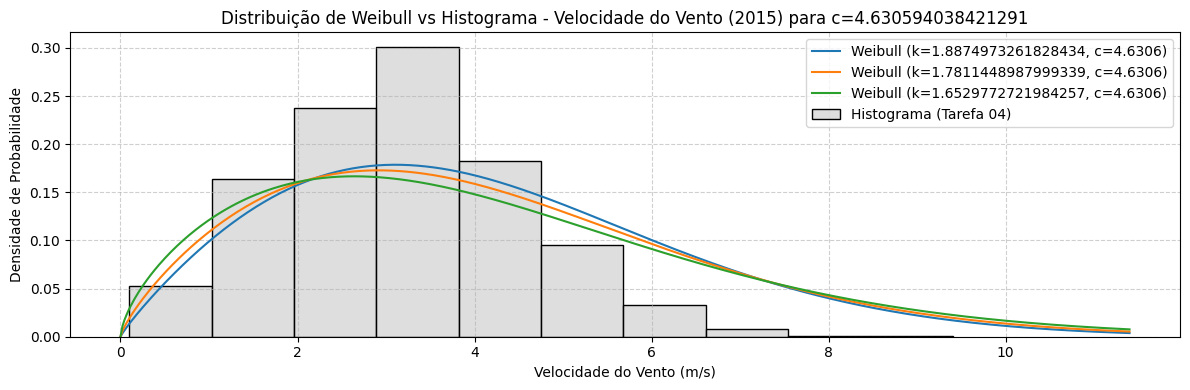

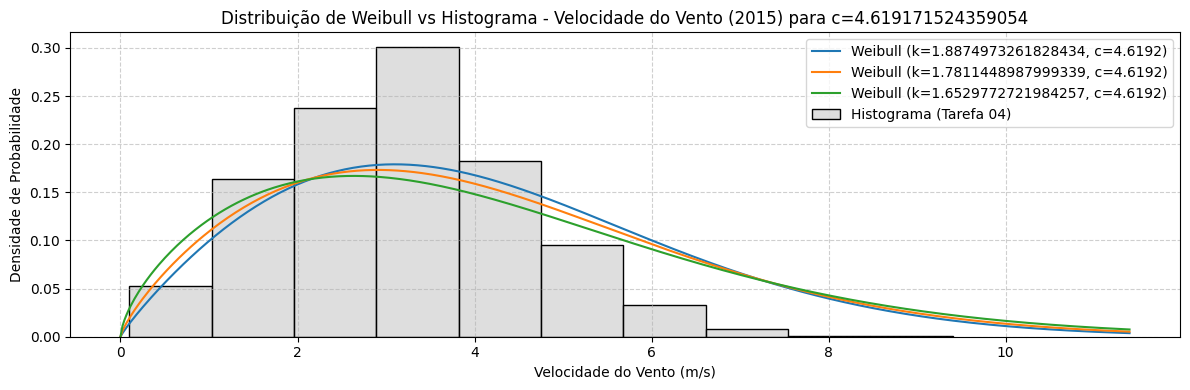

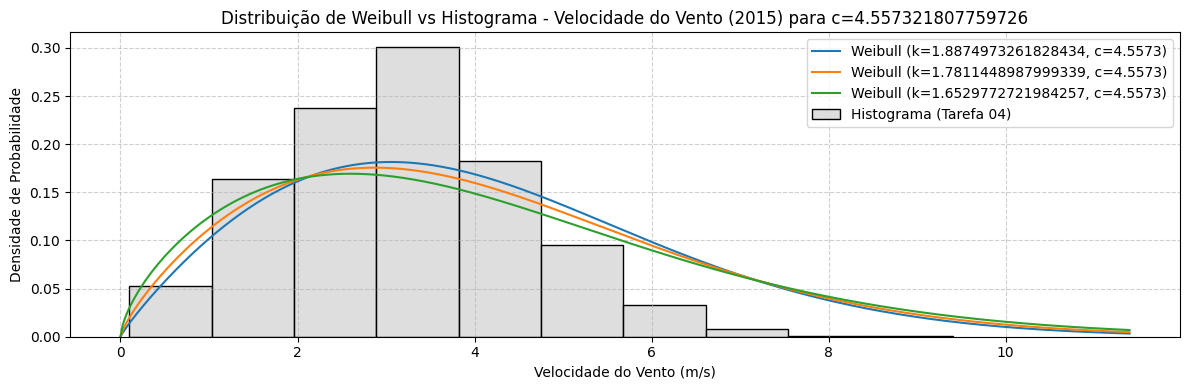

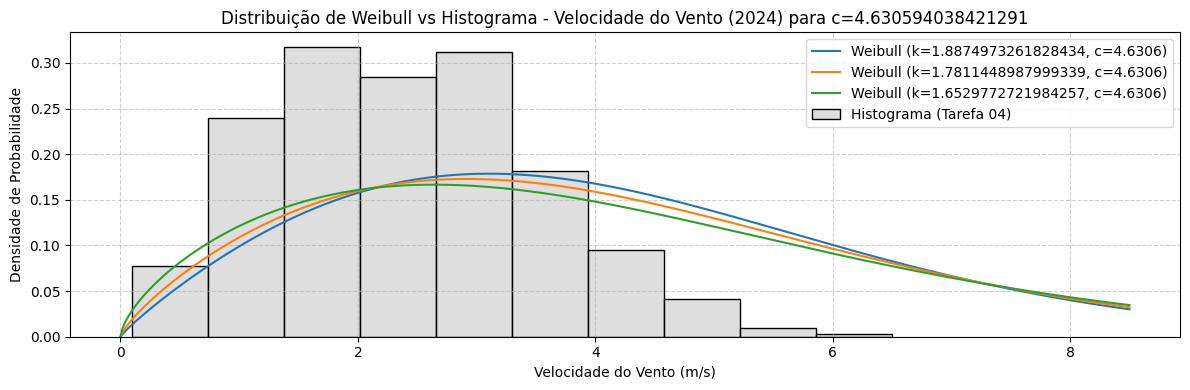

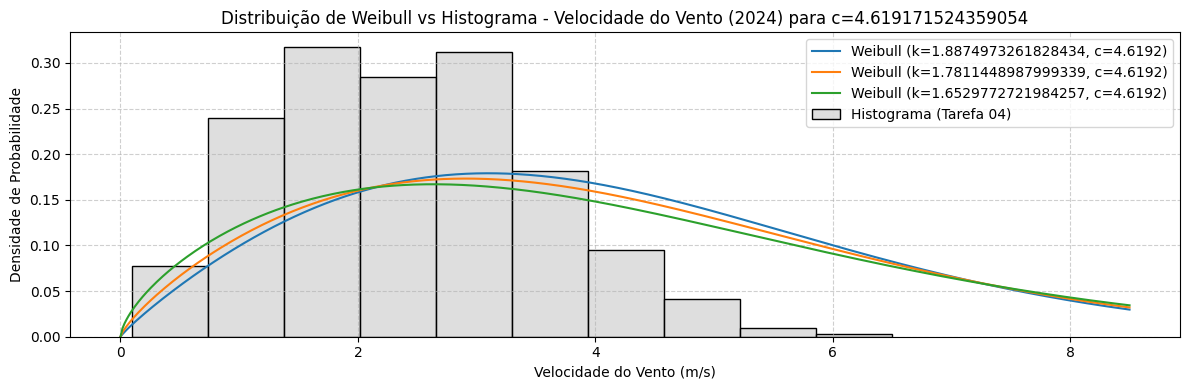

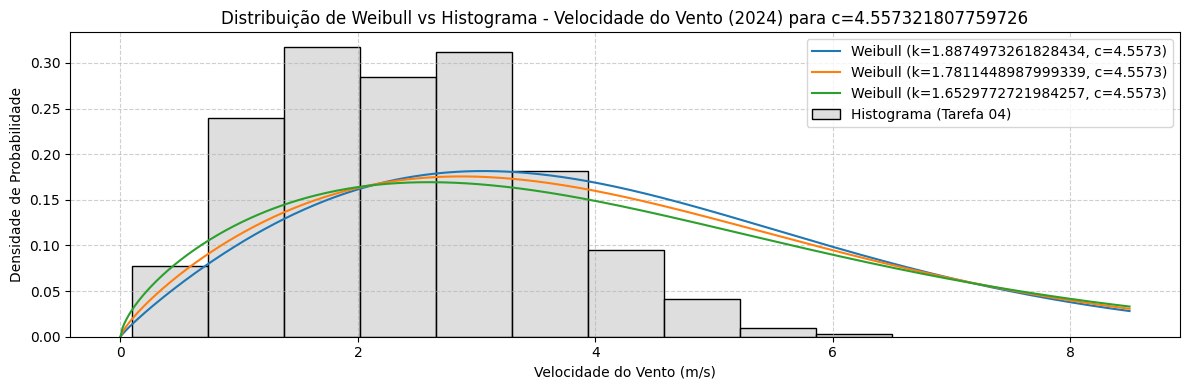

[np.float64(4.630594038421291), np.float64(4.619171524359054), np.float64(4.557321807759726)]


In [6]:
# MODELAGEM 01 - Caicó


# IMPORTAÇÃO E LIMPEZA DAS COLUNAS

caminhos5 = {
    '2015': '/content/drive/MyDrive/eolica/caico/INMET_NE_RN_A316_CAICO_01-01-2015_A_31-12-2015.CSV',
    '2024': '/content/drive/MyDrive/eolica/caico/INMET_NE_RN_A316_CAICO_01-01-2024_A_31-12-2024.CSV'
}


# TRATAMENTO PARA CADA ANO

dfs71 = {}

for ano71, caminho5 in caminhos5.items():
    df71 = pd.read_csv(caminho5, skiprows=8, encoding='latin1', sep=';', decimal=',', on_bad_lines='skip')
    df71 = df71.loc[:, ~df71.columns.duplicated()]
    df71.drop(columns=[col for col in colunas_remover if col in df71.columns], inplace=True)
    if 'VENTO, VELOCIDADE HORARIA (m/s)' in df71.columns:
        df71.rename(columns={'VENTO, VELOCIDADE HORARIA (m/s)': 'VELOCIDADE (m/s)'}, inplace=True)
    df71['VELOCIDADE (m/s)'] = pd.to_numeric(df71['VELOCIDADE (m/s)'], errors='coerce')
    df71['VELOCIDADE (m/s)'].replace([-9999, -9999.0], np.nan, inplace=True)
    df71['Ano'] = int(ano71)
    dfs71[ano71] = df71

dfs72 = {}

for ano72, caminho5 in caminhos5.items():
    df72 = pd.read_csv(caminho5, skiprows=8, encoding='latin1', sep=';', decimal=',', on_bad_lines='skip')
    df72 = df72.loc[:, ~df72.columns.duplicated()]
    df72.drop(columns=[col for col in colunas_remover if col in df72.columns], inplace=True)
    if 'VENTO, VELOCIDADE HORARIA (m/s)' in df72.columns:
        df72.rename(columns={'VENTO, VELOCIDADE HORARIA (m/s)': 'VELOCIDADE (m/s)'}, inplace=True)
    df72['VELOCIDADE (m/s)'] = pd.to_numeric(df72['VELOCIDADE (m/s)'], errors='coerce')
    df72['VELOCIDADE (m/s)'].replace([-9999, -9999.0], np.nan, inplace=True)
    df72['Ano'] = int(ano72)
    dfs72[ano72] = df72

ano_escolhido71 = '2015'
dados71 = dfs71[ano_escolhido71]['VELOCIDADE (m/s)'].dropna()

ano_escolhido72 = '2024'
dados72 = dfs72[ano_escolhido72]['VELOCIDADE (m/s)'].dropna()

# DISTRIBUIIÇÃO DE WEIBULL

c_values = [c_energia, c_mom, scale_c]  # Parâmetro de escala
k_values = [k_energia, k_mom, shape_k] # Parâmetro de forma

# Eixo x para a função PDF
x = np.linspace(0, dados71.max() + 2, 500)
x2 = np.linspace(0, dados72.max() + 2, 500)

# Função da PDF da Weibull
def weibull_pdf(x, k, c): # 2015
    return (k / c) * (x / c)**(k - 1) * np.exp(-(x / c)**k)
def weibull_pdf2(x2, k, c): # 2024
    return (k / c) * (x2 / c)**(k - 1) * np.exp(-(x2 / c)**k)

# Função para identificar o método com base em c
def identificar_metodo(c):
    if np.isclose(c, 4.630594038421291, atol=1e-5):
        return "Método da Energia Padrão"
    elif np.isclose(c, 4.619171524359054, atol=1e-5):
        return "Método dos Momentos"
    else:
        return "Método da Máxima Verossimilhança"

##############################  2015   #################################
for c in c_values:
  metodo = identificar_metodo(c)
  # Plotar histograma relacionado
  plt.figure(figsize=(12, 4))
  sns.histplot(dados71, bins=10, stat='density', color='lightgray', edgecolor='black', label='Histograma (Tarefa 04)')

  # Adiciona curvas da Weibull
  for k in k_values:
      pdf = weibull_pdf(x, k, c)
      plt.plot(x, pdf, label=f'Weibull (k={k}, c={c:.4f})')

  # Configurações do gráfico
  plt.title(f'Distribuição de Weibull vs Histograma - Velocidade do Vento ({ano_escolhido71}) para c={c}')
  plt.xlabel('Velocidade do Vento (m/s)')
  plt.ylabel('Densidade de Probabilidade')
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.6) # Plotar histograma normalizado (density=True)
  plt.tight_layout()
  plt.show()

##############################  2024   ################################
for c in c_values:
  metodo = identificar_metodo(c)
  # Plotar histograma relacionado
  plt.figure(figsize=(12,4))
  sns.histplot(dados72, bins=10, stat='density', color='lightgray', edgecolor='black', label='Histograma (Tarefa 04)')

  # Adiciona curvas da Weibull

  for k in k_values:
      pdf = weibull_pdf2(x2, k, c)
      plt.plot(x2, pdf, label=f'Weibull (k={k}, c={c:.4f})')


  # Configurações do gráfico

  plt.title(f'Distribuição de Weibull vs Histograma - Velocidade do Vento ({ano_escolhido72}) para c={c}')
  plt.xlabel('Velocidade do Vento (m/s)')
  plt.ylabel('Densidade de Probabilidade')
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.6) # Plotar histograma normalizado (density=True)
  plt.tight_layout()
  plt.show()
print(c_values)

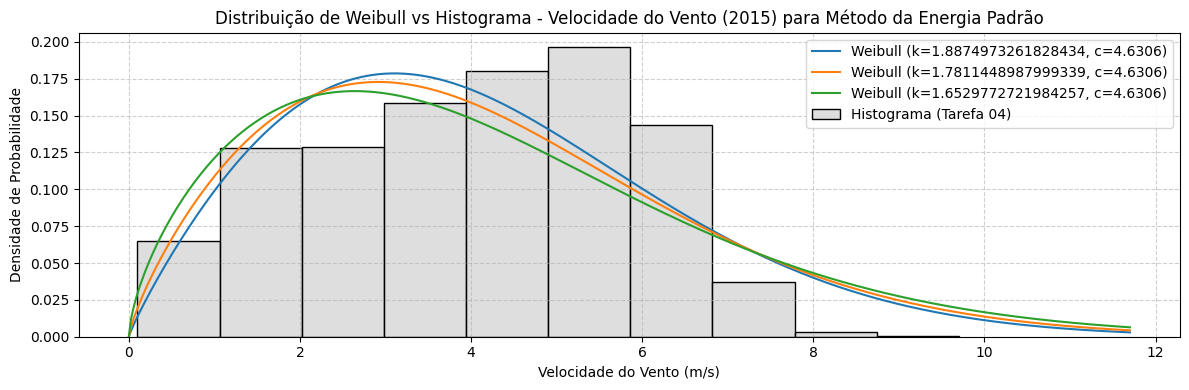

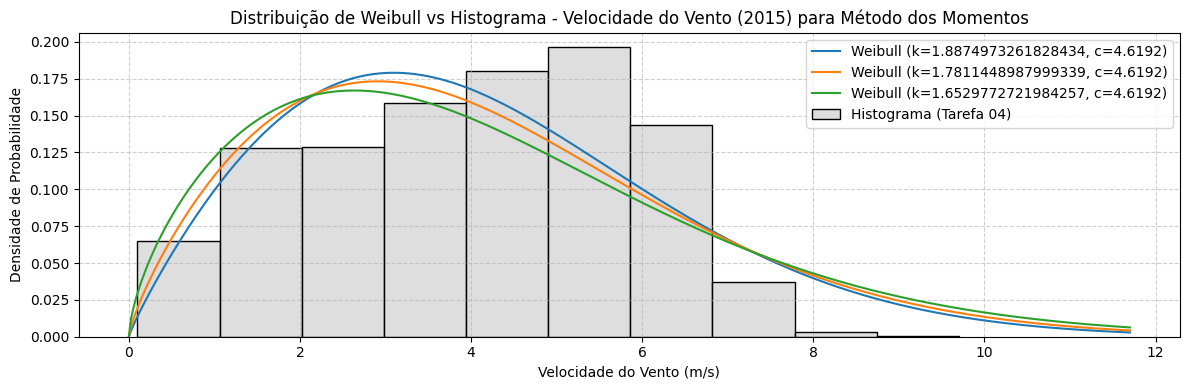

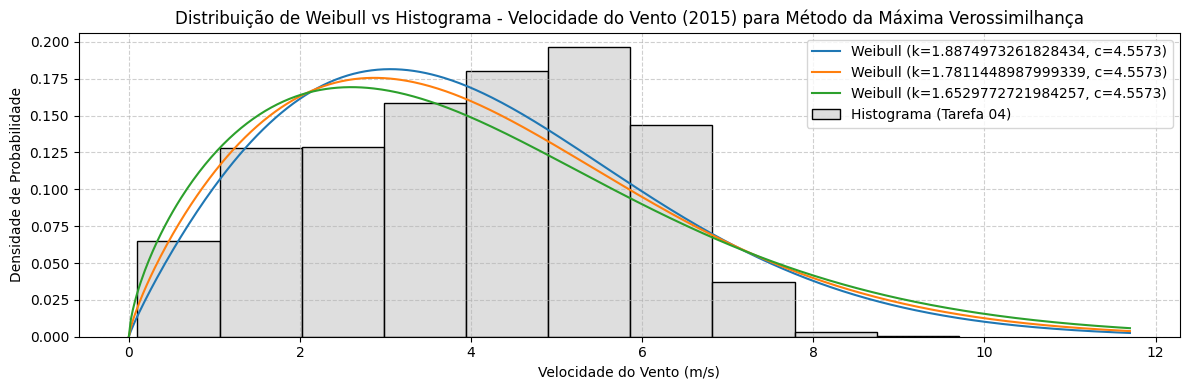

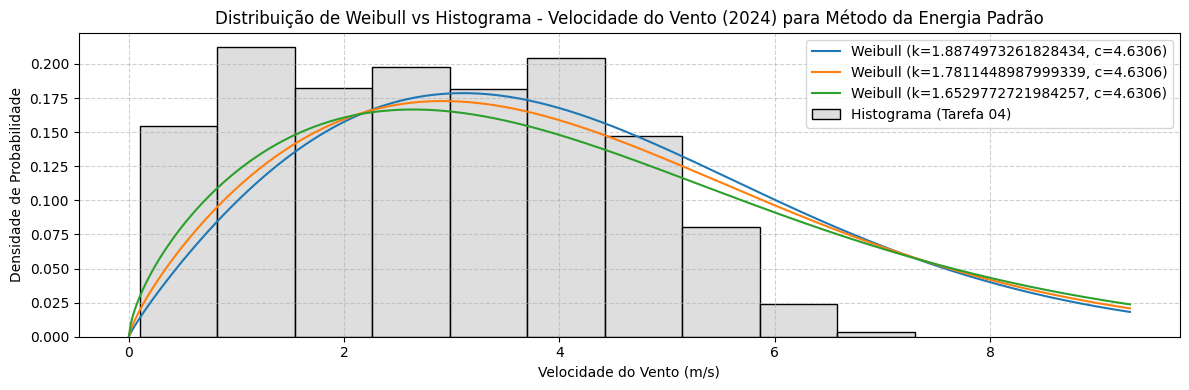

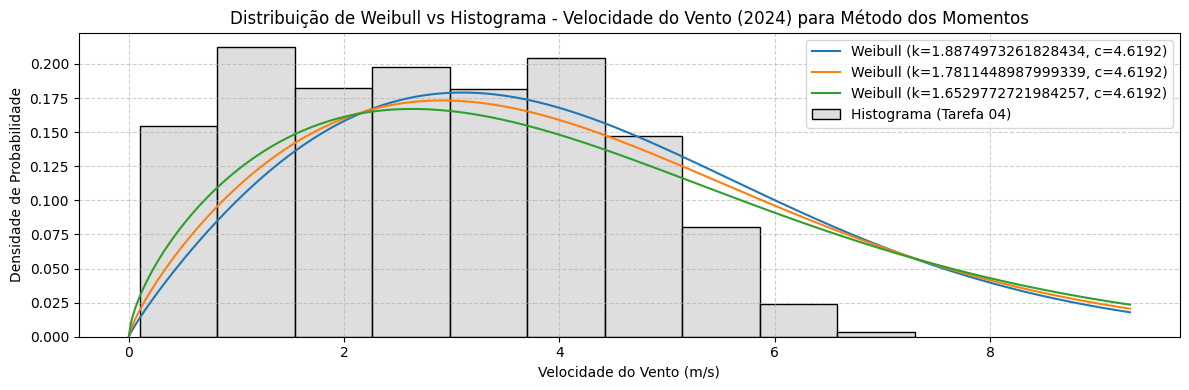

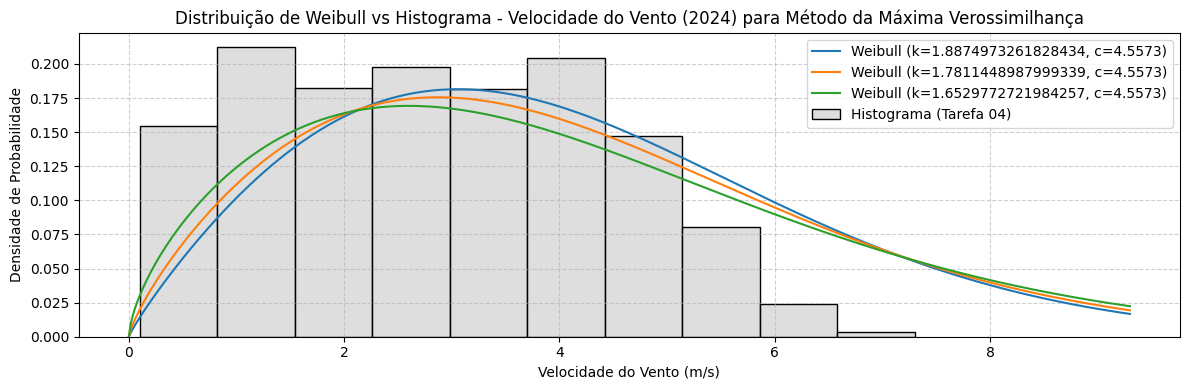

In [8]:
# MODELAGEM 02 - Mossoró


# IMPORTAÇÃO E LIMPEZA DAS COLUNAS

caminhos6 = {
    '2015': '/content/drive/MyDrive/eolica/mossoro/INMET_NE_RN_A318_MOSSORO_01-01-2015_A_31-12-2015.CSV',
    '2024': '/content/drive/MyDrive/eolica/mossoro/INMET_NE_RN_A318_MOSSORO_01-01-2024_A_31-12-2024.CSV'
}


# TRATAMENTO PARA CADA ANO

dfs73 = {}

for ano73, caminho6 in caminhos6.items():
    df73 = pd.read_csv(caminho6, skiprows=8, encoding='latin1', sep=';', decimal=',', on_bad_lines='skip')
    df73 = df73.loc[:, ~df73.columns.duplicated()]
    df73.drop(columns=[col for col in colunas_remover if col in df73.columns], inplace=True)
    if 'VENTO, VELOCIDADE HORARIA (m/s)' in df73.columns:
        df73.rename(columns={'VENTO, VELOCIDADE HORARIA (m/s)': 'VELOCIDADE (m/s)'}, inplace=True)
    df73['VELOCIDADE (m/s)'] = pd.to_numeric(df73['VELOCIDADE (m/s)'], errors='coerce')
    df73['VELOCIDADE (m/s)'].replace([-9999, -9999.0], np.nan, inplace=True)
    df73['Ano'] = int(ano73)
    dfs73[ano73] = df73

dfs74 = {}

for ano74, caminho6 in caminhos6.items():
    df74 = pd.read_csv(caminho6, skiprows=8, encoding='latin1', sep=';', decimal=',', on_bad_lines='skip')
    df74 = df74.loc[:, ~df74.columns.duplicated()]
    df74.drop(columns=[col for col in colunas_remover if col in df74.columns], inplace=True)
    if 'VENTO, VELOCIDADE HORARIA (m/s)' in df74.columns:
        df74.rename(columns={'VENTO, VELOCIDADE HORARIA (m/s)': 'VELOCIDADE (m/s)'}, inplace=True)
    df74['VELOCIDADE (m/s)'] = pd.to_numeric(df74['VELOCIDADE (m/s)'], errors='coerce')
    df74['VELOCIDADE (m/s)'].replace([-9999, -9999.0], np.nan, inplace=True)
    df74['Ano'] = int(ano74)
    dfs74[ano74] = df74

ano_escolhido73 = '2015'
dados73 = dfs73[ano_escolhido73]['VELOCIDADE (m/s)'].dropna()

ano_escolhido74 = '2024'
dados74 = dfs74[ano_escolhido74]['VELOCIDADE (m/s)'].dropna()

# DISTRIBUIÇÃO DE WEIBULL

c_values = [c_energia, c_mom, scale_c]  # Parâmetro de escala
k_values = [k_energia, k_mom, shape_k]  # Parâmetro de forma

# Eixo x para a função PDF
x = np.linspace(0, dados73.max() + 2, 500)
x2 = np.linspace(0, dados74.max() + 2, 500)

# Funções da PDF da Weibull
def weibull_pdf(x, k, c):  # 2015
    return (k / c) * (x / c)**(k - 1) * np.exp(-(x / c)**k)

def weibull_pdf2(x2, k, c):  # 2024
    return (k / c) * (x2 / c)**(k - 1) * np.exp(-(x2 / c)**k)

# Função para identificar o método com base em c
def identificar_metodo(c):
    if np.isclose(c, 4.630594038421291, atol=1e-5):
        return "Método da Energia Padrão"
    elif np.isclose(c, 4.619171524359054, atol=1e-5):
        return "Método dos Momentos"
    else:
        return "Método da Máxima Verossimilhança"

##############################  2015   #################################
for c in c_values:
    metodo = identificar_metodo(c)
    plt.figure(figsize=(12, 4))
    sns.histplot(dados73, bins=10, stat='density', color='lightgray', edgecolor='black', label='Histograma (Tarefa 04)')

    for k in k_values:
        pdf = weibull_pdf(x, k, c)
        plt.plot(x, pdf, label=f'Weibull (k={k}, c={c:.4f})')

    plt.title(f'Distribuição de Weibull vs Histograma - Velocidade do Vento ({ano_escolhido73}) para {metodo}')
    plt.xlabel('Velocidade do Vento (m/s)')
    plt.ylabel('Densidade de Probabilidade')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

##############################  2024   #################################
for c in c_values:
    metodo = identificar_metodo(c)
    plt.figure(figsize=(12, 4))
    sns.histplot(dados74, bins=10, stat='density', color='lightgray', edgecolor='black', label='Histograma (Tarefa 04)')

    for k in k_values:
        pdf = weibull_pdf2(x2, k, c)
        plt.plot(x2, pdf, label=f'Weibull (k={k}, c={c:.4f})')

    plt.title(f'Distribuição de Weibull vs Histograma - Velocidade do Vento ({ano_escolhido74}) para {metodo}')
    plt.xlabel('Velocidade do Vento (m/s)')
    plt.ylabel('Densidade de Probabilidade')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


## Tarefa 08 - Weibull

Calcular a produtividade para cada caso visto na Tarefa 7, utilizando as duas distribuições colocadas nesses slides (Rayleigh e Weibull), considerando os 3 diferentes metodos utilizados e as duas localidades e dois anos diferentes.

Ui=9.5, Uf=10.0, c=4.557321807759726, k=1.6529772721984257
c_values = [np.float64(4.630594038421291), np.float64(4.619171524359054), np.float64(4.557321807759726)]
k_values = [np.float64(1.8874973261828434), np.float64(1.7811448987999339), np.float64(1.6529772721984257)]


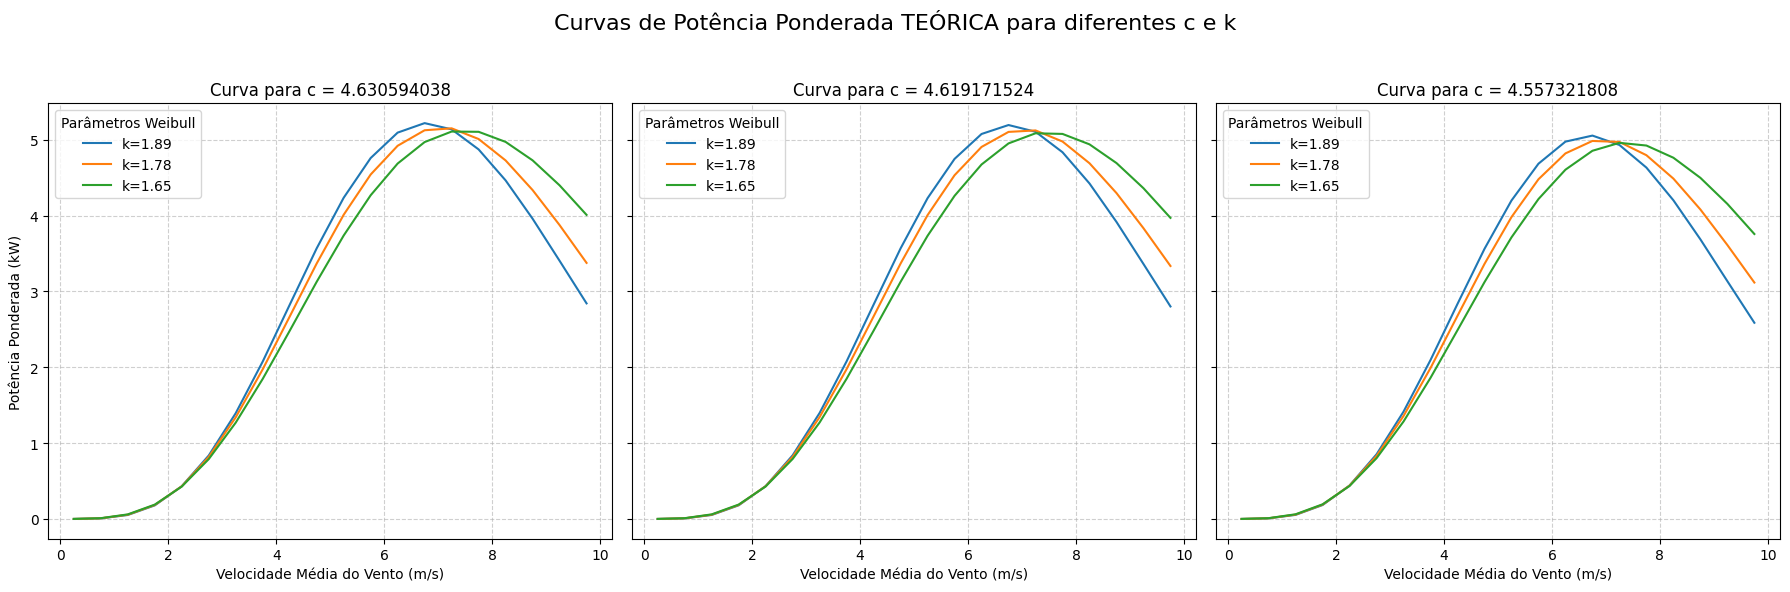

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dados e parâmetros
velocidades = v_filtrados
D = 50
A = (np.pi * D**2) / 4
T = 25
rho = (353.4 * (1 - (171.26 / 45271))**5.2624) / (273.15 + T)
Cp = 0.4
Ui = 2
Uf = 10

c_values = [c_energia, c_mom, scale_c]
k_values = [k_energia, k_mom, shape_k]

def prob_weibull_faixa(Ui, Uf, c, k):
    return np.exp(-((Ui / c) ** k)) - np.exp(-((Uf / c) ** k))
    print(f"Ui={Ui}, Uf={Uf}, c={c}, k={k}, p={p}")
def potencia_turbina(v, rho, A, Cp):
    return 0.5 * rho * A * Cp * v**3 / 1000  # em kW

# Faixas
limites = np.arange(0, 10.5, 0.5)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, c in enumerate(c_values):
    ax = axs[idx]

    for k in k_values:
        velocidades_plot = []
        potencias_ponderadas = []

        for i in range(len(limites) - 1):
            Ui = limites[i]
            Uf = limites[i + 1]
            v_med = (Ui + Uf) / 2

            p_faixa = prob_weibull_faixa(Ui, Uf, c, k)
            p_turbina = potencia_turbina(v_med, rho, A, Cp)
            pot_ponderada = p_faixa * p_turbina

            velocidades_plot.append(v_med)
            potencias_ponderadas.append(pot_ponderada)

        ax.plot(velocidades_plot, potencias_ponderadas, label=f'k={round(k, 2)}')

    ax.set_title(f'Curva para c = {round(c, 9)}')
    ax.set_xlabel('Velocidade Média do Vento (m/s)')
    if idx == 0:
        ax.set_ylabel('Potência Ponderada (kW)')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(title="Parâmetros Weibull")
print(f"Ui={Ui}, Uf={Uf}, c={c}, k={k}")
print("c_values =", c_values)
print("k_values =", k_values)

plt.suptitle("Curvas de Potência Ponderada TEÓRICA para diferentes c e k", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

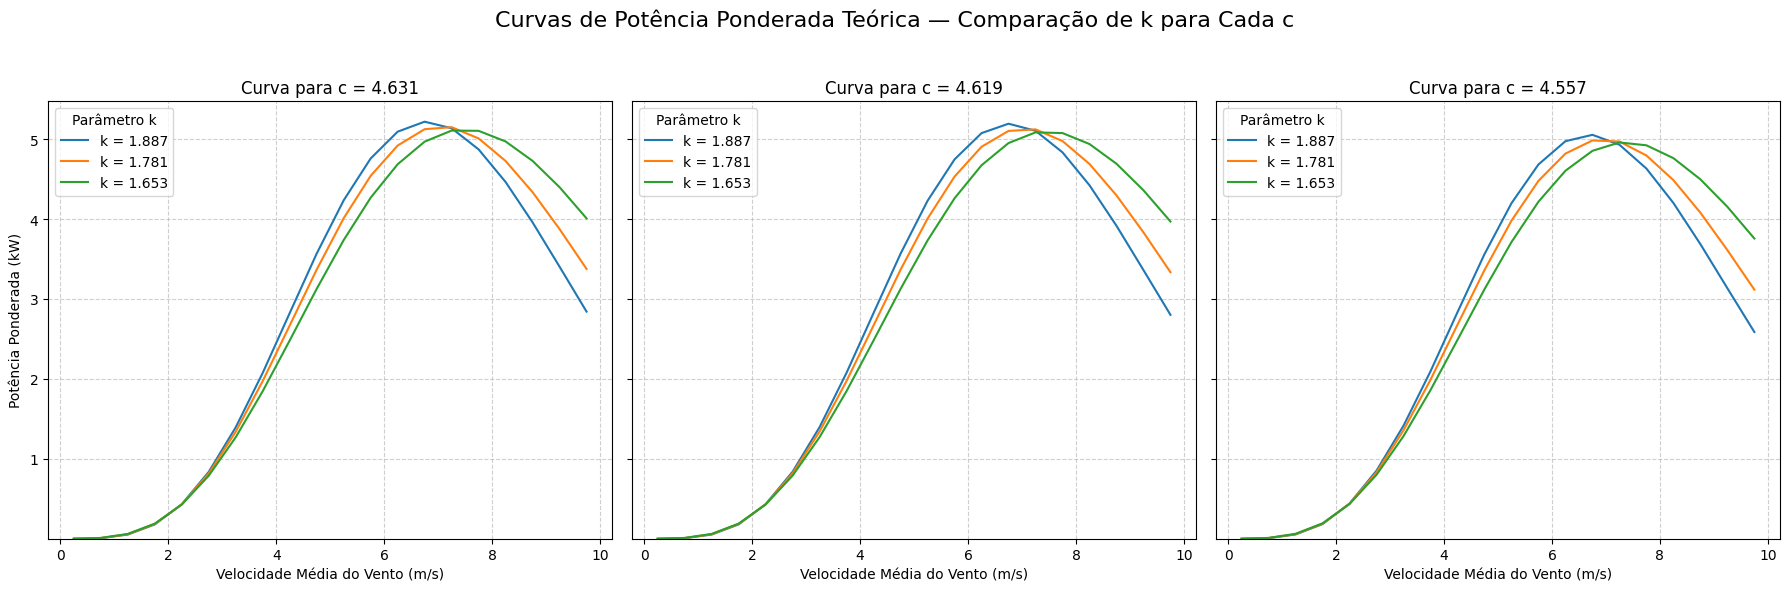

In [63]:
# TEST -CODIGO MAIS SENSIVEL A VARIAÇÃO

# === Parâmetros fixos ===
D = 50  # diâmetro da turbina (m)
A = (np.pi * D**2) / 4
T = 25  # temperatura (°C)
rho = (353.4 * (1 - (171.26 / 45271))**5.2624) / (273.15 + T)
Cp = 0.4  # coeficiente de potência

# === Valores reais dos parâmetros Weibull ===
c_values = [np.float64(4.630594038421291), np.float64(4.619171524359054), np.float64(4.557321807759726)]
k_values = [np.float64(1.8874973261828434), np.float64(1.7811448987999339), np.float64(1.6529772721984257)]

# === Funções ===
def prob_weibull_faixa(Ui, Uf, c, k):
    return np.exp(-((Ui / c) ** k)) - np.exp(-((Uf / c) ** k))

def potencia_turbina(v, rho, A, Cp):
    return 0.5 * rho * A * Cp * v**3 / 1000  # kW

# === Faixas de velocidade ===
limites = np.arange(0, 10.5, 0.5)
velocidades_plot = [(limites[i] + limites[i + 1]) / 2 for i in range(len(limites) - 1)]

# === Inicialização da figura ===
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# === Armazenar todos os valores para ajustar o eixo Y globalmente ===
all_potencias = []

# === Plotagem ===
for idx, c in enumerate(c_values):
    ax = axs[idx]
    for k in k_values:
        potencias_ponderadas = []
        for i in range(len(limites) - 1):
            Ui, Uf = limites[i], limites[i + 1]
            v_med = (Ui + Uf) / 2
            p_faixa = prob_weibull_faixa(Ui, Uf, c, k)
            p_turbina = potencia_turbina(v_med, rho, A, Cp)
            pot_ponderada = p_faixa * p_turbina
            potencias_ponderadas.append(pot_ponderada)

        all_potencias.extend(potencias_ponderadas)
        label = f"k = {k:.3f}"
        ax.plot(velocidades_plot, potencias_ponderadas, label=label)

    ax.set_title(f"Curva para c = {c:.3f}")
    ax.set_xlabel("Velocidade Média do Vento (m/s)")
    if idx == 0:
        ax.set_ylabel("Potência Ponderada (kW)")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(title="Parâmetro k")

# === Ajuste global do eixo Y ===
ymin, ymax = min(all_potencias) * 0.95, max(all_potencias) * 1.05
for ax in axs:
    ax.set_ylim([ymin, ymax])

# === Título e layout final ===
plt.suptitle("Curvas de Potência Ponderada Teórica — Comparação de k para Cada c", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## A partir de dados de fabricantes

Traçar a curva de potencia de 2 tipos diferentes de turbinas e falar sobre suas características e fazer um estudo de potência usando o weibull calculado nas atividades passadas em uma região.

TURBINA 01:
    
    Manufacturer: Siemens (Allemagne)
    Model: SWT-2.3-82 VS
    Rated power: 2,300 kW
    Rotor diameter: 82.4 m
    Swept area: 5,333 m²
    Specific area: 2.32 m²/kW
    Number of blades: 3
    Power control: Pitch
    Commissioning: 2004
    
    - Rotor:
    Minimum rotor speed: 6 rd/min
    Maximum rotor speed: 18 rd/min
    Cut-in wind speed: 3,5 m/s
    Rated wind speed: 15 m/s
    Cut-off wind speed: 25 m/s
    Manufacturer: Siemens

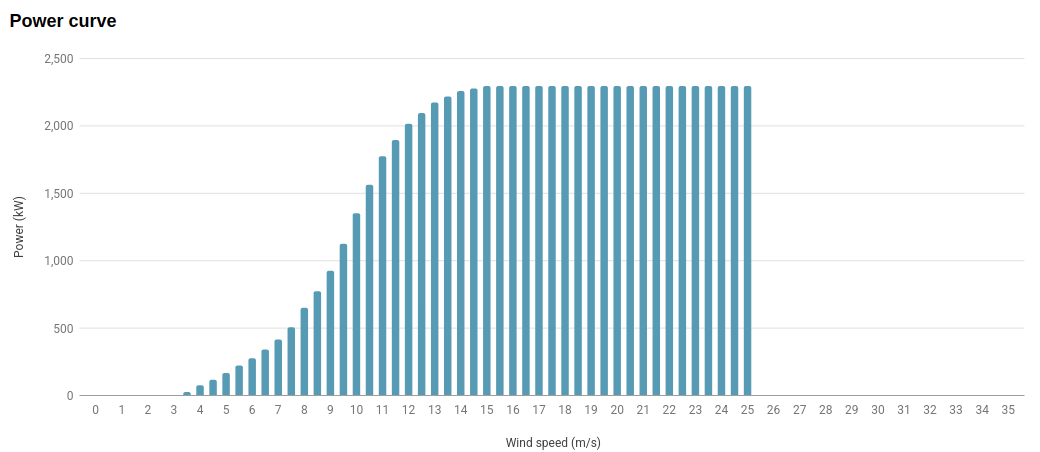

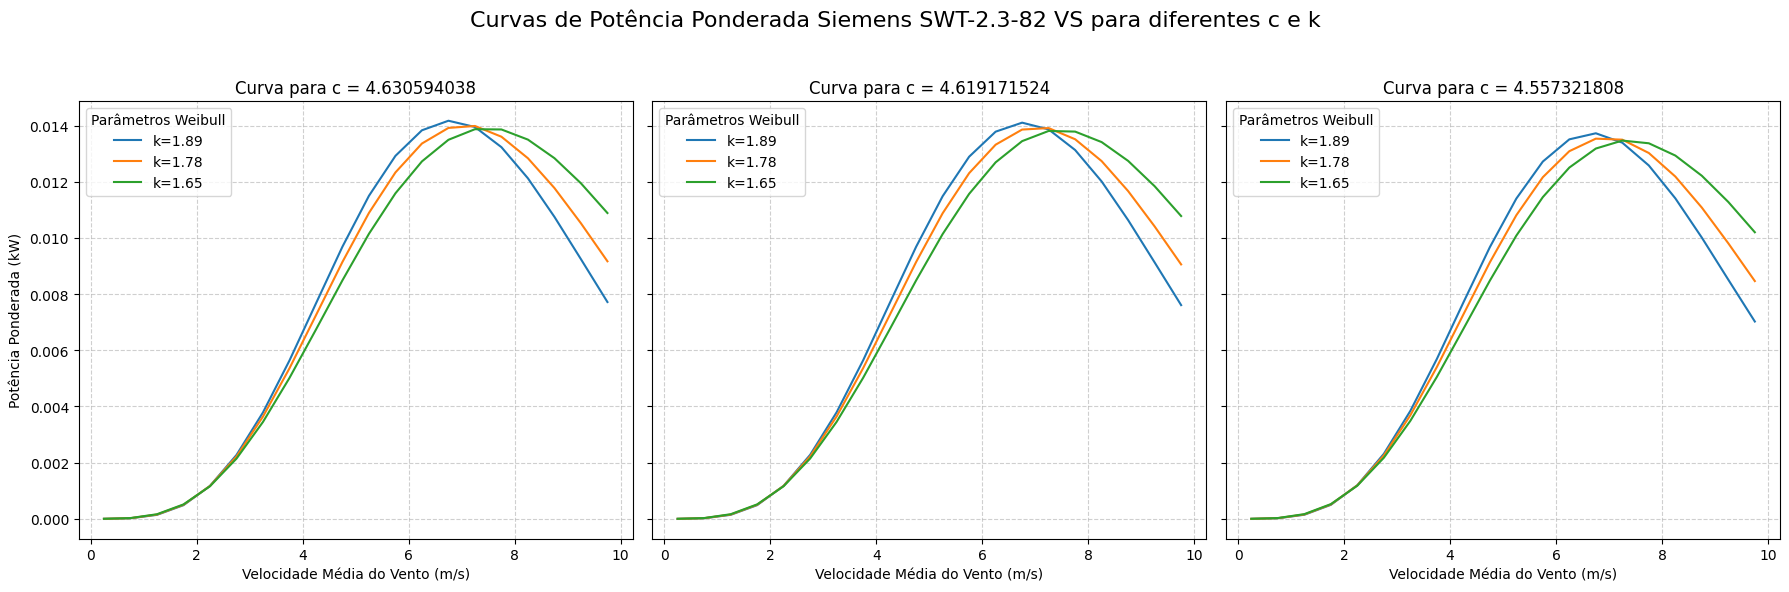

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dados de velocidade (assuma que v_filtrados está definido)
velocidades = v_filtrados

# Parâmetros da turbina Siemens SWT-2.3-82 VS
D = 82.4  # diâmetro do rotor em metros
A = 5.333  # área varrida em m² (fornecida)
T = 25  # temperatura ambiente em °C
rho = (353.4 * (1 - (171.26 / 45271))**5.2624) / (273.15 + T)
Cp = 0.4  # coeficiente de potência típico
Ui = 3.5
Uf = 25
Um = 15

# Valores estimados pelos métodos Tarefa 07
c_values = [c_energia, c_mom, scale_c]
k_values = [k_energia, k_mom, shape_k]

def prob_weibull_faixa(Ui, Uf, c, k):
    return np.exp(-((Ui / c) ** k)) - np.exp(-((Uf / c) ** k))

def potencia_turbina(v, rho, A, Cp):
    if v < Ui or v > Uf:
        return 0
    elif v >= Um:
        return 2300  # potência nominal da turbina
    else:
        return 0.5 * rho * A * Cp * v**3 / 1000  # em kW
# Faixas
limites = np.arange(0, 10.5, 0.5)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, c in enumerate(c_values):
    ax = axs[idx]

    for k in k_values:
        velocidades_plot = []
        potencias_ponderadas = []

        for i in range(len(limites) - 1):
            Ui = limites[i]
            Uf = limites[i + 1]
            v_med = (Ui + Uf) / 2

            p_faixa = prob_weibull_faixa(Ui, Uf, c, k)
            p_turbina = potencia_turbina(v_med, rho, A, Cp)
            pot_ponderada = p_faixa * p_turbina

            velocidades_plot.append(v_med)
            potencias_ponderadas.append(pot_ponderada)

        ax.plot(velocidades_plot, potencias_ponderadas, label=f'k={round(k, 2)}')

    ax.set_title(f'Curva para c = {round(c, 9)}')
    ax.set_xlabel('Velocidade Média do Vento (m/s)')
    if idx == 0:
        ax.set_ylabel('Potência Ponderada (kW)')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(title="Parâmetros Weibull")

plt.suptitle("Curvas de Potência Ponderada Siemens SWT-2.3-82 VS para diferentes c e k", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

TURBINA 02:
    
    Manufacturer: Nordex (Allemagne)
    Model: N90/2300
    Rated power: 2,300 kW
    Rotor diameter: 90 m
    Swept area: 6,362 m²
    Specific area: 2.77 m²/kW
    Number of blades: 3
    Power control: Pitch
    Commissioning: 2002
    
    - Rotor:
    Minimum rotor speed: 9,6 rd/min
    Maximum rotor speed: 16,8 rd/min
    Cut-in wind speed: 4 m/s
    Rated wind speed: 13 m/s
    Cut-off wind speed: 25 m/s
    Manufacturer: LM Glasfiber, Nordex

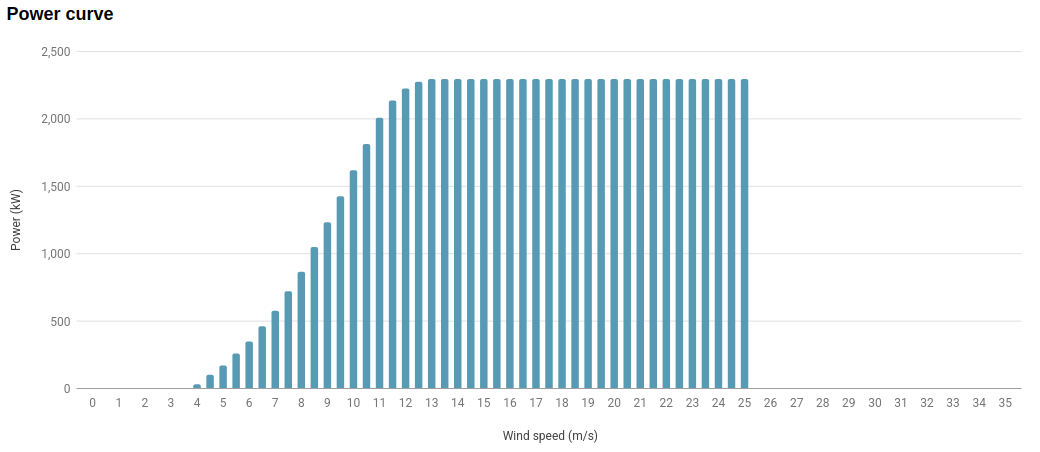

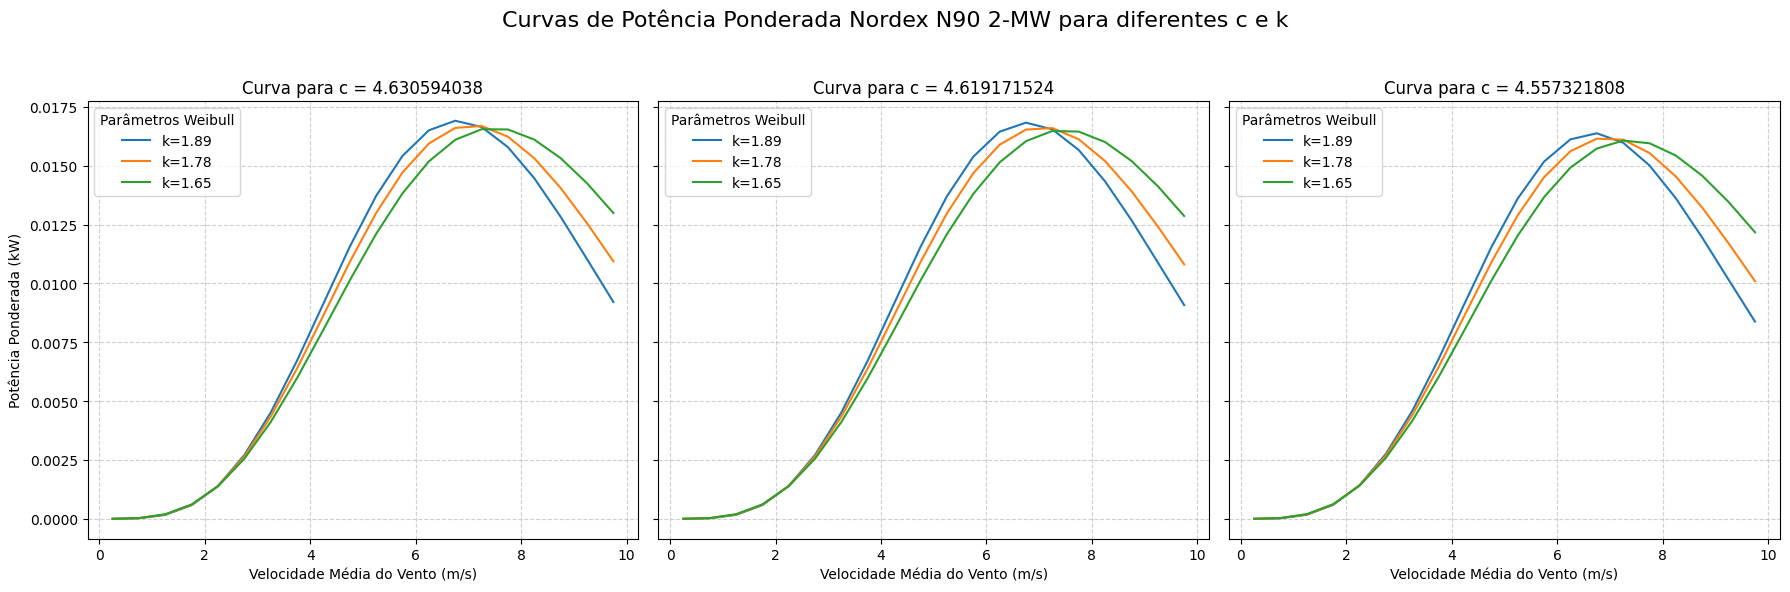

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dados de velocidade (assuma que v_filtrados está definido)
velocidades = v_filtrados

# Parâmetros da turbina Nordex N90 2-MW
D = 90  # diâmetro do rotor em metros
A = 6.362  # área varrida em m² (fornecida)
T = 25  # temperatura ambiente em °C
rho = (353.4 * (1 - (171.26 / 45271))**5.2624) / (273.15 + T)
Cp = 0.4  # coeficiente de potência típico
Ui = 4
Uf = 25
Um = 13

# Valores estimados pelos métodos Tarefa 07
c_values = [c_energia, c_mom, scale_c]
k_values = [k_energia, k_mom, shape_k]

def prob_weibull_faixa(Ui, Uf, c, k):
    return np.exp(-((Ui / c) ** k)) - np.exp(-((Uf / c) ** k))

def potencia_turbina(v, rho, A, Cp):
    if v < Ui or v > Uf:
        return 0
    elif v >= Um:
        return 2300  # potência nominal da turbina
    else:
        return 0.5 * rho * A * Cp * v**3 / 1000  # em kW
# Faixas
limites = np.arange(0, 10.5, 0.5)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, c in enumerate(c_values):
    ax = axs[idx]

    for k in k_values:
        velocidades_plot = []
        potencias_ponderadas = []

        for i in range(len(limites) - 1):
            Ui = limites[i]
            Uf = limites[i + 1]
            v_med = (Ui + Uf) / 2

            p_faixa = prob_weibull_faixa(Ui, Uf, c, k)
            p_turbina = potencia_turbina(v_med, rho, A, Cp)
            pot_ponderada = p_faixa * p_turbina

            velocidades_plot.append(v_med)
            potencias_ponderadas.append(pot_ponderada)

        ax.plot(velocidades_plot, potencias_ponderadas, label=f'k={round(k, 2)}')

    ax.set_title(f'Curva para c = {round(c, 9)}')
    ax.set_xlabel('Velocidade Média do Vento (m/s)')
    if idx == 0:
        ax.set_ylabel('Potência Ponderada (kW)')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(title="Parâmetros Weibull")

plt.suptitle("Curvas de Potência Ponderada Nordex N90 2-MW para diferentes c e k", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()